# Testing
### Bevölkerung nach Stadtquartier, Herkunft, Geschlecht und Alter, seit 1993
Datum: 26.01.2022

### Importiere die notwendigen Packages

In [2]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [3]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [4]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [5]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [6]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 1 datenstand:  -1 time.struct_time(tm_year=2022, tm_mon=1, tm_mday=26, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=2, tm_yday=26, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [7]:
epoch = datetime.datetime(1960, 1, 1)

### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903/

In [8]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod";
print(status)

prod


In [10]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903/download/BEV390OD3903.csv"
else:
    fp = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH\bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903\BEV390OD3903.csv"   

print(fp)

https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903/download/BEV390OD3903.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [19]:
# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
    parse_dates=['StichtagDatJahr'],
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #date_parser=lambda s: epoch + datetime.timedelta(days=int(s)),
    low_memory=False    
    )

print('done')

done


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [20]:
#data2betested.head(6)

In [25]:
data2betested.dtypes

StichtagDatJahr    datetime64[ns]
QuarSort                    int64
QuarCd                      int64
QuarLang                   object
AlterVSort                  int64
AlterVCd                    int64
AlterVKurz                  int64
AlterV05Sort                int64
AlterV05Kurz               object
HerkunftLang               object
HerkunftCd                  int64
HerkunftSort                int64
SexCd                       int64
SexKurz                    object
AnzBestWir                  int64
dtype: object

In [26]:
data2betested.shape

(345386, 15)

Beschreibe einzelne Attribute

In [27]:
data2betested.describe()

,QuarSort,QuarCd,AlterVSort,AlterVCd,AlterVKurz,AlterV05Sort,HerkunftCd,HerkunftSort,SexCd,AnzBestWir
count,345386,345386,345386,345386,345386,345386,345386,345386,345386,345386
mean,66,66,46,46,46,10,1,1,2,31
std,35,35,27,27,27,5,0,0,0,32
min,11,11,0,0,0,1,1,1,1,0
25%,34,34,23,23,23,5,1,1,1,7
50%,71,71,46,46,46,10,1,1,2,21
75%,92,92,69,69,69,14,2,2,2,44
max,123,123,111,111,111,21,2,2,2,248


Wie viele Nullwerte gibt es im Datensatz?

In [28]:
data2betested.isnull().sum()

StichtagDatJahr    0
QuarSort           0
QuarCd             0
QuarLang           0
AlterVSort         0
AlterVCd           0
AlterVKurz         0
AlterV05Sort       0
AlterV05Kurz       0
HerkunftLang       0
HerkunftCd         0
HerkunftSort       0
SexCd              0
SexKurz            0
AnzBestWir         0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [29]:
data2betested = data2betested.set_index("StichtagDatJahr")
#data2betested = data2betested.drop(columns=["StichtagDatMM"])

In [30]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345386 entries, 1993-01-01 to 2020-01-01
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   QuarSort      345386 non-null  int64 
 1   QuarCd        345386 non-null  int64 
 2   QuarLang      345386 non-null  object
 3   AlterVSort    345386 non-null  int64 
 4   AlterVCd      345386 non-null  int64 
 5   AlterVKurz    345386 non-null  int64 
 6   AlterV05Sort  345386 non-null  int64 
 7   AlterV05Kurz  345386 non-null  object
 8   HerkunftLang  345386 non-null  object
 9   HerkunftCd    345386 non-null  int64 
 10  HerkunftSort  345386 non-null  int64 
 11  SexCd         345386 non-null  int64 
 12  SexKurz       345386 non-null  object
 13  AnzBestWir    345386 non-null  int64 
dtypes: int64(10), object(4)
memory usage: 39.5+ MB


Int64Index([1], dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [16]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [32]:
data2betested.loc["2009"].head(4)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,QuarSort,QuarCd,QuarLang,AlterVSort,AlterVCd,AlterVKurz,AlterV05Sort,AlterV05Kurz,HerkunftLang,HerkunftCd,HerkunftSort,SexCd,SexKurz,AnzBestWir
StichtagDatJahr,,,,,,,,,,,,,,
2009-01-01,11,11,Rathaus,0,0,0,1,0-4,Schweizer/in,1,1,1,M,12
2009-01-01,11,11,Rathaus,0,0,0,1,0-4,Schweizer/in,1,1,2,W,10
2009-01-01,11,11,Rathaus,0,0,0,1,0-4,Ausländer/in,2,2,1,M,2
2009-01-01,11,11,Rathaus,0,0,0,1,0-4,Ausländer/in,2,2,2,W,5


### Visualisierungen nach Zeitausschnitten

In [34]:
data2betested.info()
#data2betested

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345386 entries, 1993-01-01 to 2020-01-01
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   QuarSort      345386 non-null  int64 
 1   QuarCd        345386 non-null  int64 
 2   QuarLang      345386 non-null  object
 3   AlterVSort    345386 non-null  int64 
 4   AlterVCd      345386 non-null  int64 
 5   AlterVKurz    345386 non-null  int64 
 6   AlterV05Sort  345386 non-null  int64 
 7   AlterV05Kurz  345386 non-null  object
 8   HerkunftLang  345386 non-null  object
 9   HerkunftCd    345386 non-null  int64 
 10  HerkunftSort  345386 non-null  int64 
 11  SexCd         345386 non-null  int64 
 12  SexKurz       345386 non-null  object
 13  AnzBestWir    345386 non-null  int64 
dtypes: int64(10), object(4)
memory usage: 47.6+ MB


#### Entwicklung Wohnbevölkerung nach Altersgruppe

In [54]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2008":"2020"]\
    .groupby(['StichtagDatJahr', 'AlterV05Kurz']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,AlterV05Kurz,sum_WBev
0,2008-01-01,0-4,18038
1,2008-01-01,95-99,802
2,2008-01-01,90-94,2637


In [55]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['AlterV05Kurz'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>300'), title="Title").encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('AlterV05Kurz', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'AlterV05Kurz','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung nach Herkunft

In [58]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["1993":"2020"]\
    .groupby(['StichtagDatJahr', 'HerkunftLang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,HerkunftLang,sum_WBev
0,1993-01-01,Ausländer/in,96857
1,1993-01-01,Schweizer/in,264041
2,1994-01-01,Ausländer/in,99298


In [59]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['HerkunftLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>300'), title="Title").encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('HerkunftLang', legend=alt.Legend(title="Herkunft", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'HerkunftLang','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Aktueller Bestand der WBev nach Quartier, Herkunft und Geschlecht

In [68]:
#data2betested.dtypes

In [88]:
myTreemapAgg = data2betested.loc["2020"]  \
    .groupby(['StichtagDatJahr', 'QuarLang', 'HerkunftLang', 'SexKurz']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

myTreemapAgg.reset_index().head(3)

,StichtagDatJahr,QuarLang,HerkunftLang,SexKurz,sum_WBev
0,2020-01-01,Hochschulen,Ausländer/in,W,91
1,2020-01-01,Hochschulen,Ausländer/in,M,120
2,2020-01-01,City,Ausländer/in,W,124


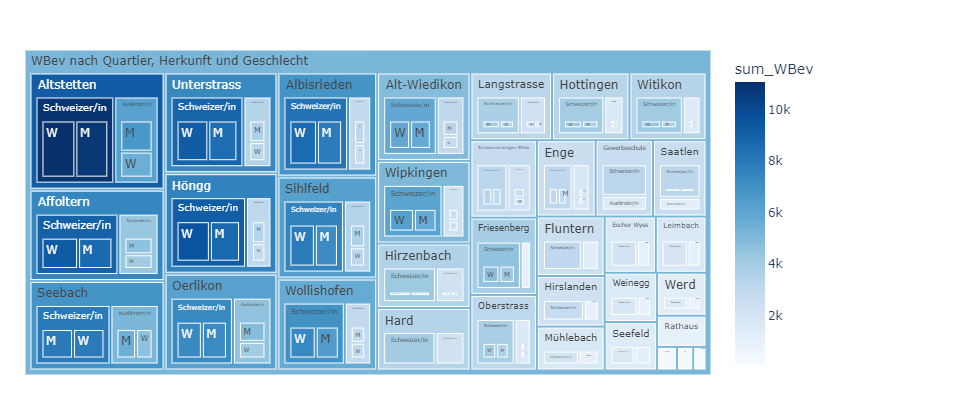

In [89]:
fig = px.treemap(myTreemapAgg.reset_index(), path=[px.Constant("WBev nach Quartier, Herkunft und Geschlecht"), 'QuarLang', 'HerkunftLang', 'SexKurz']
                 , values='sum_WBev'
                 , color='sum_WBev'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=400
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

#### Aktueller Bestand der WBev nach Quartier und Herkunft

In [90]:
myTreemapAgg = data2betested.loc["2020"]  \
    .groupby(['StichtagDatJahr', 'QuarLang', 'HerkunftLang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

myTreemapAgg.reset_index().head(3)

,StichtagDatJahr,QuarLang,HerkunftLang,sum_WBev
0,2020-01-01,Hochschulen,Ausländer/in,211
1,2020-01-01,City,Ausländer/in,262
2,2020-01-01,Lindenhof,Ausländer/in,295


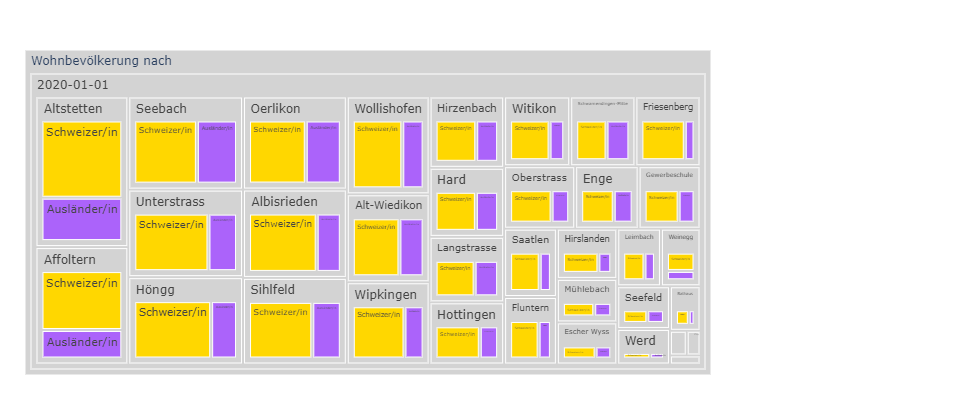

In [91]:
myTreemapAgg = data2betested.loc["2020"]  \
    .groupby(['StichtagDatJahr', 'QuarLang', 'HerkunftLang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

fig = px.treemap(myTreemapAgg.reset_index(), path=[px.Constant("Wohnbevölkerung nach "), 'StichtagDatJahr', 'QuarLang', 'HerkunftLang']
                 , values='sum_WBev'
                 , color='HerkunftLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'Ausländer/in':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }         
                 , color_discrete_map={'(?)':'lightgrey','Schweizer/in':'gold', 'SP':'#FF3030' }               
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])   
                 ,height=400
                 ,width=1100
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [117]:
#data2betested.dtypes

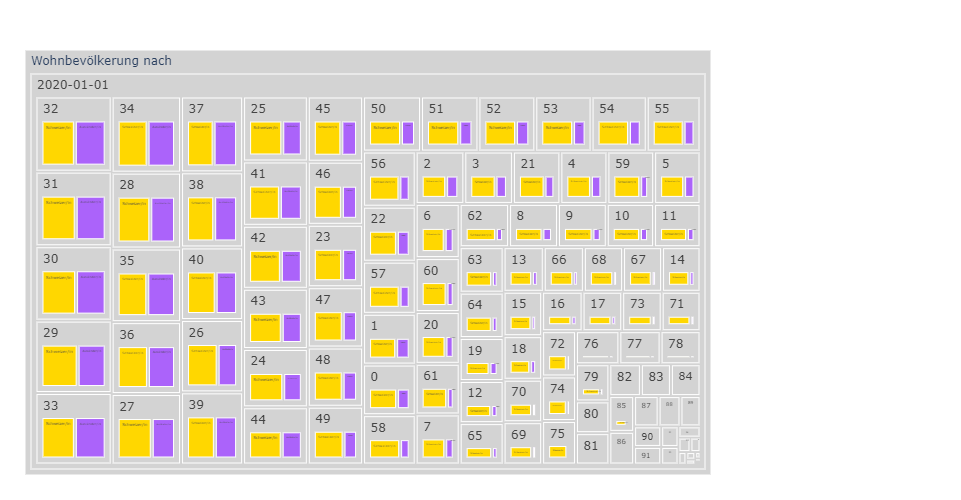

In [116]:
myTreemapAgg = data2betested.loc["2020"]  \
    .groupby(['StichtagDatJahr', 'AlterVKurz', 'AlterVSort', 'HerkunftLang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

fig = px.treemap(myTreemapAgg.reset_index(), path=[px.Constant("Wohnbevölkerung nach "), 'StichtagDatJahr', 'AlterVKurz', 'HerkunftLang']
                 , values='sum_WBev'
                 , color='HerkunftLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'Ausländer/in':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }         
                 , color_discrete_map={'(?)':'lightgrey','Schweizer/in':'gold', 'SP':'#FF3030' }               
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])
                 ,height=500
                 ,width=1100
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

-------------------------- hier gestoppt

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

In [153]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Wenn die Daten lokal agelegt sind, dann kannst Du folgendes machen:
##input_stadtquartiere = r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/stzh.adm_statistische_quartiere_map.json"
##df_stadtquartiere = gpd.read_file(input_stadtquartiere)
##df_stadtquartiere.head(2)
#df_stadtkreise.dtypes

geojson_url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url)

df_adm_statistische_quartiere_map.head(5)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."
2,adm_statistische_quartiere_map.3,Kreis 8,8,3,32,Mühlebach,82,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ..."
3,adm_statistische_quartiere_map.4,Kreis 8,8,4,31,Seefeld,81,"POLYGON ((8.54795 47.36500, 8.54805 47.36489, ..."
4,adm_statistische_quartiere_map.7,Kreis 4,4,7,16,Werd,41,"POLYGON ((8.53300 47.37394, 8.53299 47.37392, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [154]:
akt_wbev_quart = data2betested.loc["2021-11"].groupby(
    ['StichtagDatJahr','StichtagDatMM','QuarCd','QuarLang']
).agg(
    {'AnzBestWir':'sum'}
)
akt_wbev_quart.head()


AnzBestWir
StichtagDatJahr StichtagDatMM QuarCd QuarLang               
2021            11            11     Rathaus            3283
                              12     Hochschulen         718
                              13     Lindenhof          1033
                              14     City                835
                              21     Wollishofen       20002

In [158]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
stadtquartiere_shapes = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(akt_wbev_quart, on='QuarCd')

stadtquartiere_shapes_joined.head(2)


,geometry,QuarCd,qname,knr,AnzBestWir
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,7342
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,5564


<AxesSubplot:>

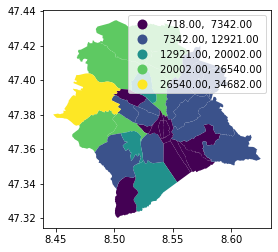

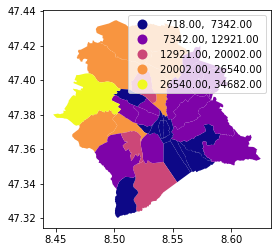

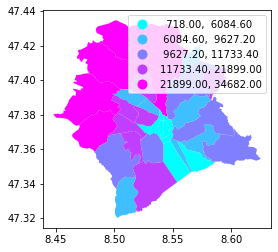

In [159]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='plasma', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=157&Source=%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs)**